### Abstract: 
The dataset collects data from a wearable accelerometer mounted on the chest. Uncalibrated Accelerometer Data are collected from 15 participants performing 7 activities. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.

### Relevant Information:
<ul>
<li>The dataset collects data from a wearable accelerometer mounted on the chest</li>
<li>Sampling frequency of the accelerometer: 52 Hz</li>
<li>Accelerometer Data are Uncalibrated</li>
<li>Number of Participants: 15</li>
<li>Number of Activities: 7</li>
<li>Data Format: CSV</li>
</ul>


### Dataset Information

- Data are separated by participant
- Each file contains the following information: 
    - sequential number
    - x acceleration
    - y acceleration
    - z acceleration
    - label
- Labels are codified by numbers    
    - Working at Computer
    - Standing Up, Walking and Going up\down stairs
    - Standing
    - Walking
    - Going Up\Down Stairs
    - Walking and Talking with Someone
    - Talking while Standing
      

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
print(tf.__version__)

from keras.layers import BatchNormalization

2.4.1


In [2]:
window_size = 50
num_sensors = 3

In [3]:
participant_file_names = []
participants = []
for i in range(1,5):
    participant_file_names.append(np.genfromtxt('%i.csv'%(i), delimiter=','))
    participants.append(np.genfromtxt('%i.csv'%(i), delimiter=','))


In [4]:
def load_dataset(participants, window_size, num_sensors):

    Y = []
    X = []

    for j in range(1, num_sensors+1):
        x = []

        for k in range(len(participants)):
            x_participant = pd.DataFrame(participants[k][:,j])
            x_participant = pd.concat([x_participant.shift(i) for i in range(window_size)], axis=1).dropna()
            x.append(x_participant)


        x = np.vstack(x)
        x = np.expand_dims(x,2)

        X.append(x.T)

    y = [] 
    
    for k in range(len(participants)): 
        y_participant = pd.DataFrame(participants[k][:,4])
        y_participant = y_participant[p-1:]
        y.append(y_participant)

    y = np.vstack(y)
    y = y.flatten()
    
    y_binary = to_categorical(y)
    X = np.array(X).squeeze().T
    
    return X, y_binary

In [5]:
X, y = load_dataset(participants, window_size, num_sensors)

NameError: name 'p' is not defined

In [156]:
X.shape

(524848, 50, 3)

In [157]:
y.shape

(524848, 8)

In [158]:
from sklearn.model_selection import train_test_split

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [187]:
X_train.shape

(367393, 50, 3)

In [188]:
X_test.shape

(157455, 50, 3)

# Plot the x, y, z traces for a given window

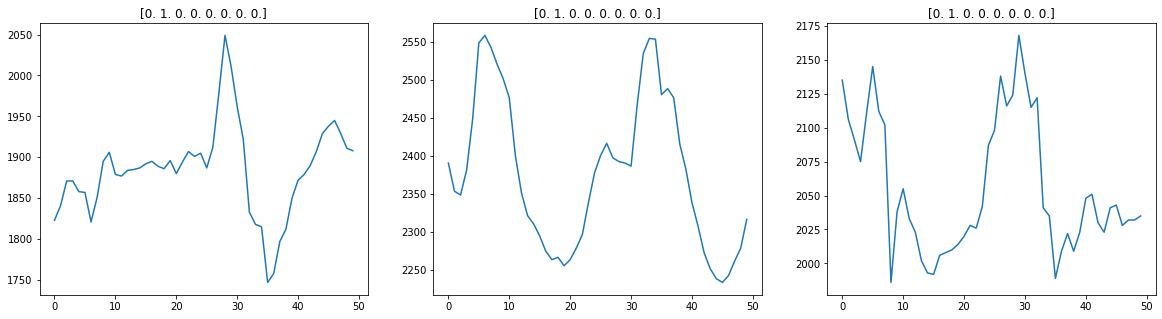

In [227]:
num_sensors = 3
fig, ax = plt.subplots(1, num_sensors, figsize=[20, 5])
for i in range(len(ax)):
    ax[i].plot(X[50000, :, i])
    ax[i].set_title(str(y[i]))

# define conv filter parameters

In [172]:
n_filters = 4
filter_size = 3
pool_size = 2

In [173]:
tf.keras.backend.clear_session()

# define the conv net model

In [220]:
tf.random.set_seed(1)

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Reshape((window_size, num_sensors), input_shape=(window_size, num_sensors)),
    BatchNormalization(),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu', 
                           padding='valid',input_shape=(window_size, num_sensors),
                          name='conv1'),
    tf.keras.layers.Conv1D(n_filters, filter_size, padding='valid', 
                           activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling1D(pool_size, name='maxpool'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])
 
    
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 50, 3)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 3)             12        
_________________________________________________________________
conv1 (Conv1D)               (None, 48, 4)             40        
_________________________________________________________________
conv2 (Conv1D)               (None, 46, 4)             52        
_________________________________________________________________
maxpool (MaxPooling1D)       (None, 23, 4)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 92)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [221]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

NameError: name 'EarlyStopping' is not defined

In [222]:
model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=1)

11482/11482 [==============================] - 43s 4ms/step - loss: 0.8245 - accuracy: 0.7249


In [223]:
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)

In [224]:
print(accuracy*100)

79.62782979011536


In [ ]:
# 82 % accurate on the test set

# Obtain the output of an intermediate layer for feature extraction?
https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

In the Functional API and Sequential API, if a layer has been called exactly once, you can retrieve its output via layer.output and its input via layer.input. This enables you do quickly instantiate feature-extraction models

In [211]:
from tensorflow.keras.models import Model
 
layer_name = "conv1"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(name=layer_name).output)

# get the data into the correct shape for the model
x_predict = X_test[50000,:,:]
x_predict = np.expand_dims(x_predict,0)
intermediate_output = intermediate_layer_model.predict(x_predict)

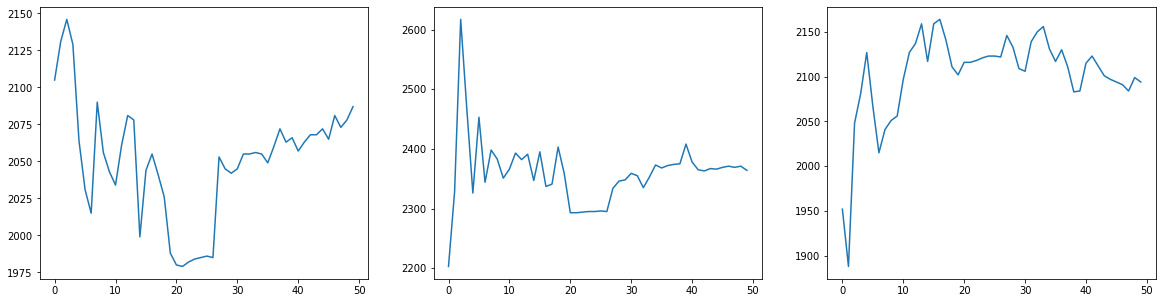

In [212]:
fig, ax = plt.subplots(1, num_sensors, figsize=[20, 5])
for i in range(num_sensors):
    ax[i].plot(x_predict[0][:, i])


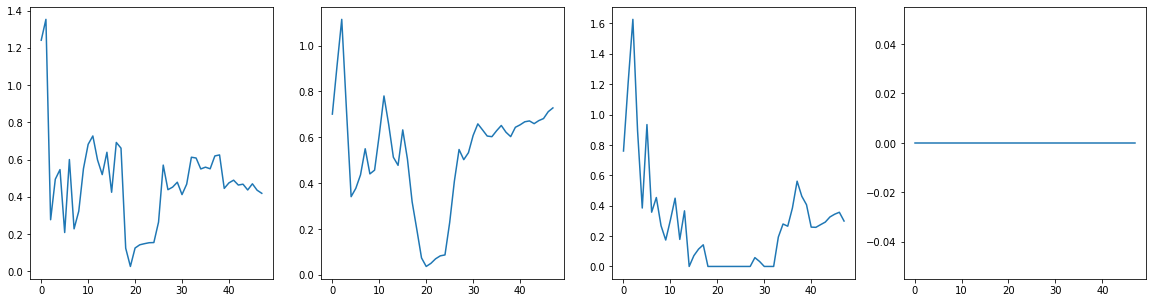

In [213]:
fig, ax = plt.subplots(1, 4, figsize=[20, 5])
for i in range(4):
    ax[i].plot(intermediate_output[0, :, i])

In [216]:
layer_name = "maxpool"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(name=layer_name).output)

# get the data into the correct shape for the model
x_predict = X_test[50000,:,:]
x_predict = np.expand_dims(x_predict,0)
intermediate_output = intermediate_layer_model.predict(x_predict)

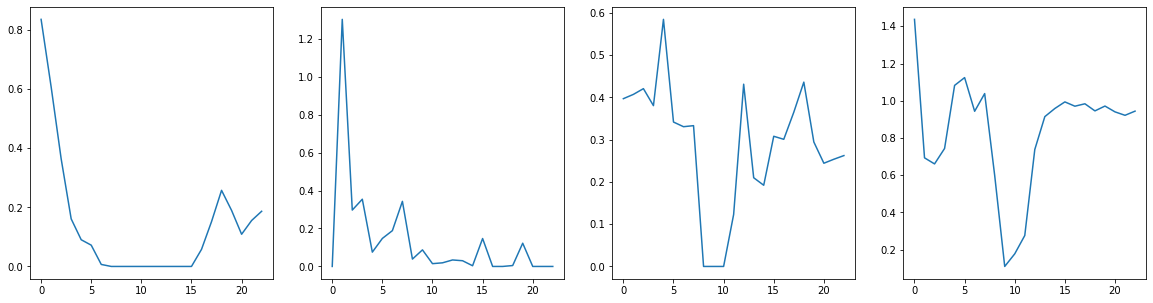

In [217]:
fig, ax = plt.subplots(1, 4, figsize=[20, 5])
for i in range(4):
    ax[i].plot(intermediate_output[0, :, i])